# Curvas ajustadas

Se quiere tomar una porción adecuada del diagrama de Nyquist para ajustar mejor la circunferencia. En la publicación de Zhang (2020) *Identifying degradation patterns of lithium ion batteries from impedance spectroscopy using machine learning* se utilizan las primeras 25 muestras para ajustar todas las circunferencias, esto es, desde los 20.000 Hz hasta los 57.4 Hz. Estas muestras no necesariamente tienen forma de circunferencia y pueden causar ruido en la etapa siguiente.



## Funciones y librerías
Se importan las librerías necesarias y las funciones a utilizar.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funciones para extraer resistencias (R) y reactancias (X).
def cycle_resistances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de resistencia
    #         de un mismo ciclo

    resistance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        reZ = df1["Re(Z)/Ohm"].to_list()
        resistance_arrays.append(reZ)
    return resistance_arrays

def cycle_reactances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de reactancia
    #         de un mismo ciclo
    reactance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        imZ = df1["-Im(Z)/Ohm"].to_list()
        reactance_arrays.append(imZ)
    return reactance_arrays

# Calculo derivada de array
def derivada_imZ(r,x):
    d = [0] 
    for i in range(len(x)-1):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        d.append(m1)
    return d

# Calculo segunda derivada de array
def derivada2_imZ(r,x):
    d2 = [0,0]
    for i in range(len(x)-2):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        m2 = (x[i+2]-x[i+1])/(r[i+2]-r[i+1])    # dx/dr en i+2
        mm2 = (m2-m1)/(r[i+2]-r[i+1])    # d2x/dr2 en i+2
        d2.append(mm2)
    return d2

#  Promedio hacia adelante
def avgs_d1(d1x):
    d1s_avg = [0,0]                 # lista que guarda los promedios
    for i in range(len(d1x)-3-2):   # calcula solo hasta 5 muestras antes del fin: no indexar mal
        avg = (d1x[i+2] + d1x[i+3] + d1x[i+4] + d1x[i+5])*0.25  # promedio 4 muestras
        d1s_avg.append(avg)
    return d1s_avg

# Algoritmo de buscar indice que ajusta mejor
def search_curve(r,x):
    # r: lista Resistencias Nyquist
    # x: lista Reactancias Nyquist
    # output: indice  
    c1 = 0                  # condicion 1
    c2 = 0                  # condicion 2
    j = 25                  # default: cortat a los 57.4 Hz
    d1 = derivada_imZ(r,x)  # Primeras derivadas
    d2 = derivada2_imZ(r,x) # Segundas derivadas
    mean4_d1 = avgs_d1(d1)  # Promedios 4 samples d1
    mean4_d2 = avgs_d1(d2)  # Promedios 4 samples d2
    # A buscar el indice
    # 1.- Buscar el indice en que el avg d1 es menor a 0.45 -> linea diagonal
    for i in range(2,30):
        if (mean4_d1[i] < 0.45):
            j = i
            c1 = 1
            break
    # 2.- A partir del indice anterior, buscar cuando avg d2 es mayor a 0 -> curva hacia arriba
    if (c1 == 1):
        for i in range(j,30):
            if (mean4_d2[i] > 0):
                j = i
                c2 = 1
                break
    return j

,time/s,cycle number,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg
0,7520.78391,1.0,20004.4530,0.40128,-0.02956,0.40237,4.21264
1,7520.92691,1.0,15829.1260,0.40688,-0.01046,0.40701,1.47198
2,7521.06891,1.0,12516.7030,0.41389,0.00415,0.41391,-0.57420
3,7521.21091,1.0,9909.4424,0.42152,0.01708,0.42187,-2.31990
4,7521.37491,1.0,7835.4800,0.42905,0.02692,0.42990,-3.59049


## Gráficos


### Funcion para corte
Recibe un dataframe leido como el de arriba. Retorna un array con los cortes para cada ciclo.

In [28]:
def index_corte(df):
    # df: dataframe de EIS
    # output: lista con indices donde cortar la curva
    r = cycle_resistances(df)
    x = cycle_reactances(df)
    indice_corte = []
    for i in range(len(r)):
        indice = search_curve(r[i],x[i])
        indice_corte.append(indice)
    return indice_corte

Lectura de Data Frames EIS

In [41]:
df_state5C2 = pd.read_csv("EIS_state_V_25C02.csv",sep=',', header=0, index_col=False)
df_state5C4 = pd.read_csv("EIS_state_V_25C04.csv",sep=',', header=0, index_col=False)
df_state5C6 = pd.read_csv("EIS_state_V_25C06.csv",sep=',', header=0, index_col=False)

indices_5C2 = index_corte(df_state5C2)
indices_5C4 = index_corte(df_state5C4)
indices_5C6 = index_corte(df_state5C6)

ciclos = []
for i in range(len(indices_5C2)):
    ciclos.append(i+1)

In [76]:
frecuencias =  {0:20004,1:15829,2:12517,3:9909,4:7835,5:6217,6:4905,
                7:3881,8:3071,9:2431,10:1923,11:1522,12:1204,13:953,
                14:754,15:596,16:472,17:373,18:295,19:234,20:185,
                21:146,22:116,23:92,24:73,25:57,26:45,27:36,28:28,
                29:22,30:18,31:14,32:11,33:9,34:7,35:6,36:4,37:3}

### Grafico N°Samples Vs Ciclos

In [ ]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
ax.plot(ciclos[0:81],indices_5C2[0:81], marker='o', label="Bateria 2")
ax.plot(ciclos[0:81],indices_5C4[0:81], marker='o', label="Bateria 4")
ax.plot(ciclos[0:81],indices_5C6[0:81], marker='o', label="Bateria 6")
ax.legend()
ax.grid()
ax.set_title("Samples a cortar - SOC5")
ax.set_ylabel("N° Sample")
ax.set_xlabel("Ciclo")

### SOC 5: graficos N° Samples vs Ciclos

Text(0.5, 0, 'N° Ciclo')

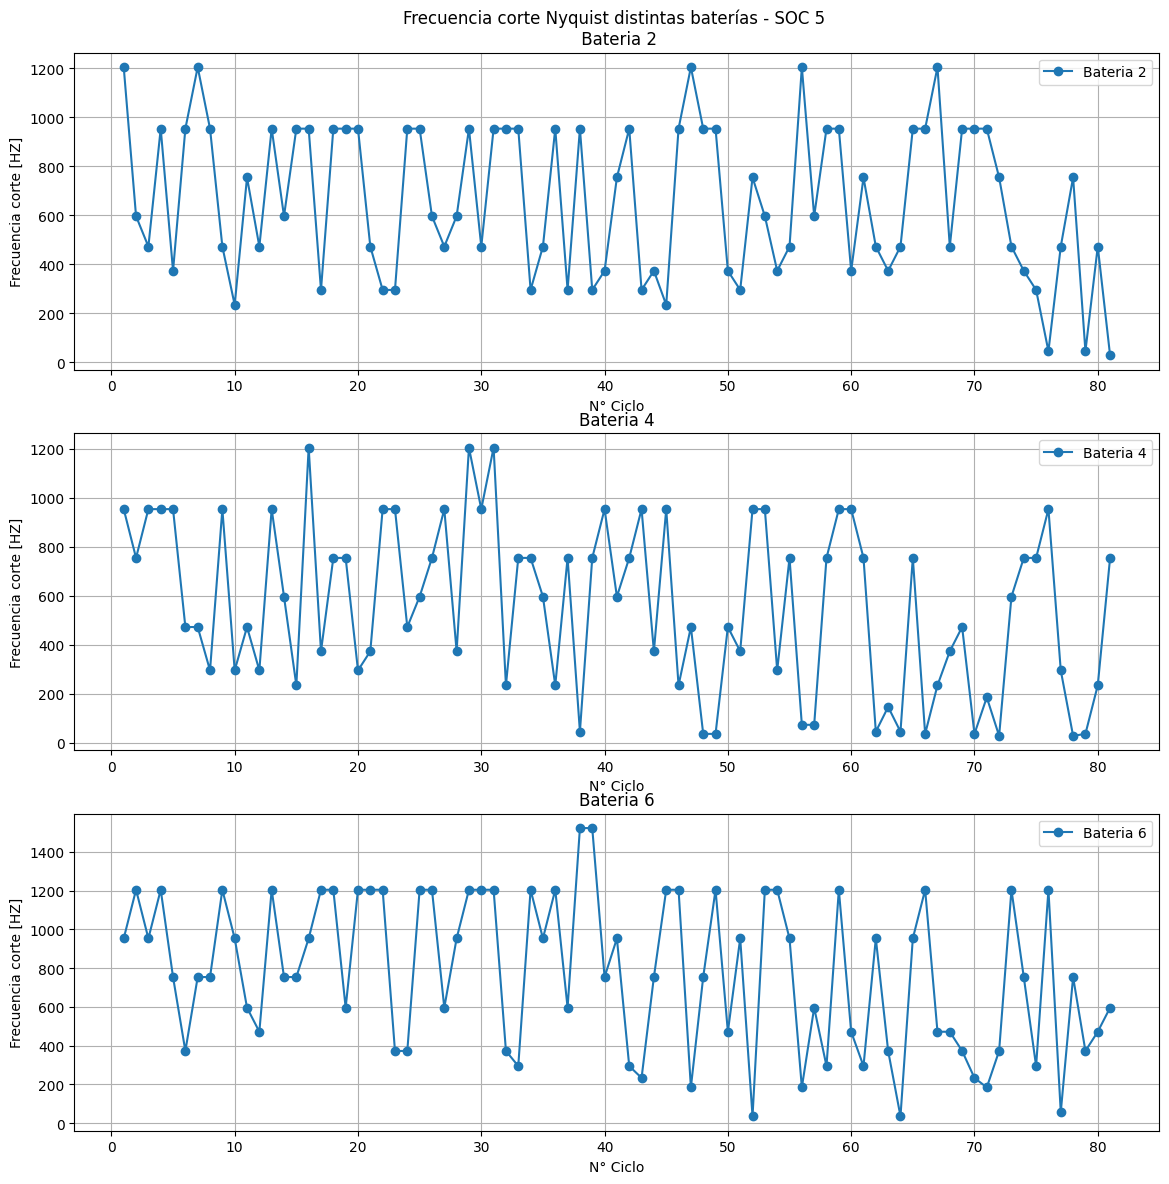

In [84]:
freq_5C2 = []
freq_5C4 = []
freq_5C6 = []
for i in range(0,81):
    freq_5C2.append(frecuencias[indices_5C2[i]])
    freq_5C4.append(frecuencias[indices_5C4[i]])
    freq_5C6.append(frecuencias[indices_5C6[i]])

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,14))

ax[0].plot(ciclos[0:81],freq_5C2[0:81], marker='o', label="Bateria 2")
ax[0].legend()
ax[0].grid()
ax[0].set_title("Frecuencia corte Nyquist distintas baterías - SOC 5 \n Bateria 2")
ax[0].set_ylabel("Frecuencia corte [HZ]")
ax[0].set_xlabel("N° Ciclo")

ax[1].plot(ciclos[0:81],freq_5C4[0:81], marker='o', label="Bateria 4")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Bateria 4")
ax[1].set_ylabel("Frecuencia corte [HZ]")
ax[1].set_xlabel("N° Ciclo")

ax[2].plot(ciclos[0:81],freq_5C6[0:81], marker='o', label="Bateria 6")
ax[2].legend()
ax[2].grid()
ax[2].set_title("Bateria 6")
ax[2].set_ylabel("Frecuencia corte [HZ]")
ax[2].set_xlabel("N° Ciclo")


### SOC 4

Text(0.5, 0, 'Ciclo')

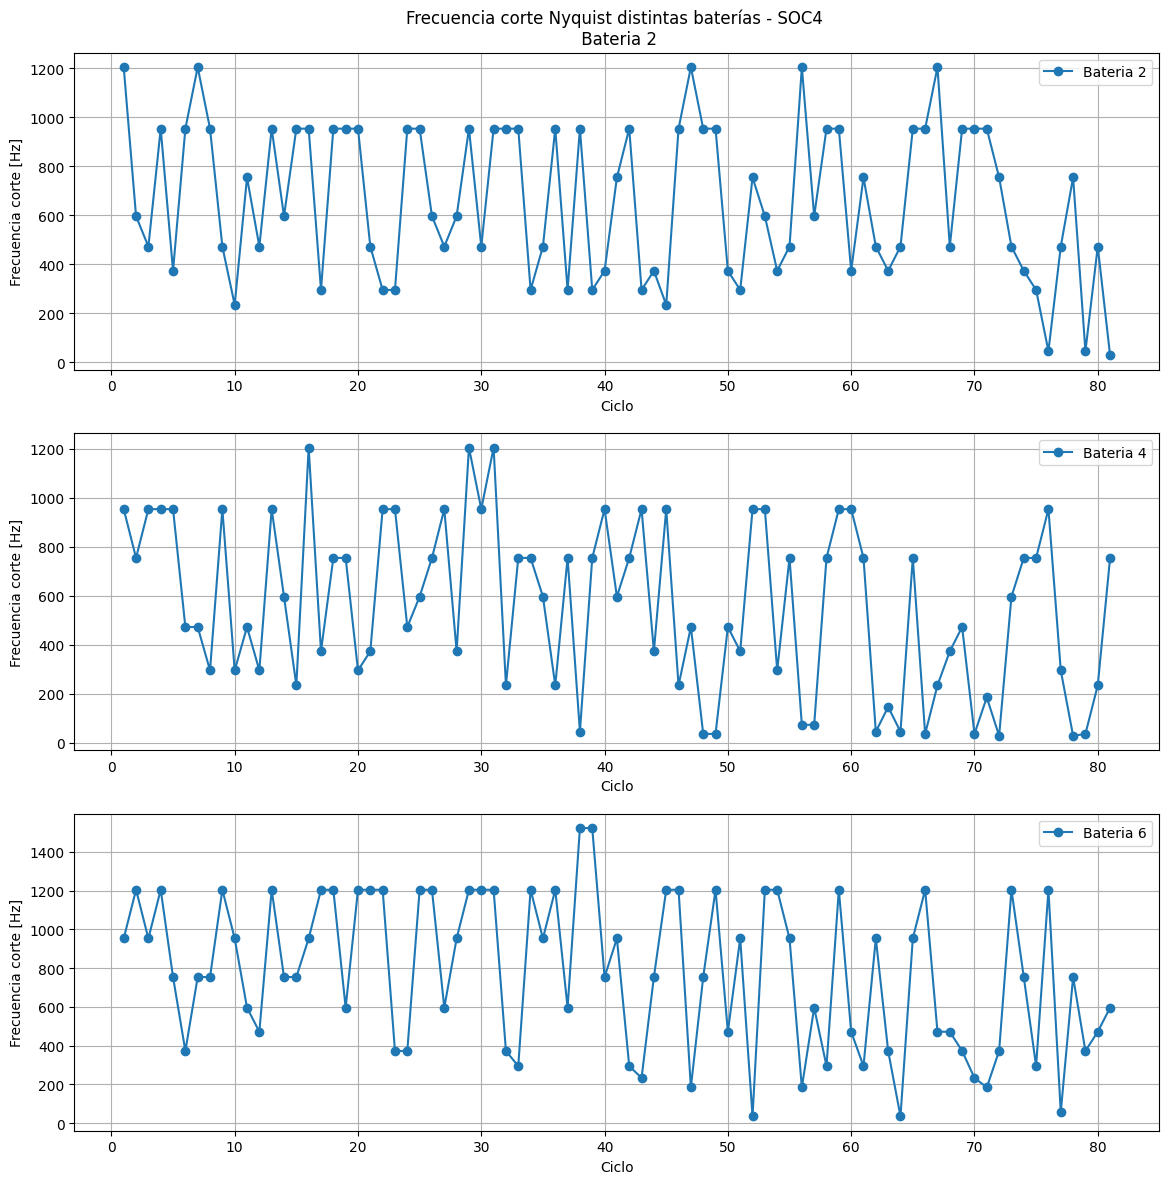

In [85]:
df_state4C2 = pd.read_csv("EIS_state_III_25C02.csv",sep=',', header=0, index_col=False)
df_state4C4 = pd.read_csv("EIS_state_III_25C04.csv",sep=',', header=0, index_col=False)
df_state4C6 = pd.read_csv("EIS_state_III_25C06.csv",sep=',', header=0, index_col=False)

indices_4C2 = index_corte(df_state5C2)
indices_4C4 = index_corte(df_state5C4)
indices_4C6 = index_corte(df_state5C6)

# DF con menor numero de ciclos (no todos tienen 350 ciclos)
N = min(len(indices_4C2), len(indices_4C4), len(indices_4C6))
ciclos = []
# Valores eje X
for i in range(N):
    ciclos.append(i+1)
# Numero de sample a frecuencia
freq_4C2 = []
freq_4C4 = []
freq_4C6 = []
for i in range(0,N):
    freq_4C2.append(frecuencias[indices_5C2[i]])
    freq_4C4.append(frecuencias[indices_5C4[i]])
    freq_4C6.append(frecuencias[indices_5C6[i]])

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,14))

ax[0].plot(ciclos[0:N],freq_4C2[0:N], marker='o', label="Bateria 2")
ax[0].legend()
ax[0].grid()
ax[0].set_title("Frecuencia corte Nyquist distintas baterías - SOC4 \n Bateria 2")
ax[0].set_ylabel("Frecuencia corte [Hz]")
ax[0].set_xlabel("Ciclo")

ax[1].plot(ciclos[0:N],freq_4C4[0:N], marker='o', label="Bateria 4")
ax[1].legend()
ax[1].grid()
#ax[1].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 5")
ax[1].set_ylabel("Frecuencia corte [Hz]")
ax[1].set_xlabel("Ciclo")

ax[2].plot(ciclos[0:N],freq_4C6[0:N], marker='o', label="Bateria 6")
ax[2].legend()
ax[2].grid()
#ax[1].set_title("Diagrama Nyquist - S1 - C1 - Ciclo 5")
ax[2].set_ylabel("Frecuencia corte [Hz]")
ax[2].set_xlabel("Ciclo")

## Ciclo constante, distintos SOC

In [110]:
# Leer datos
eis_soc1 = pd.read_csv("EIS_state_I_25C04.csv",sep=',', header=0, index_col=False)
eis_soc2 = pd.read_csv("EIS_state_II_25C04.csv",sep=',', header=0, index_col=False)
eis_soc3 = pd.read_csv("EIS_state_III_25C03.csv",sep=',', header=0, index_col=False)
eis_soc4 = pd.read_csv("EIS_state_IV_25C04.csv",sep=',', header=0, index_col=False)
eis_soc5 = pd.read_csv("EIS_state_V_25C04.csv",sep=',', header=0, index_col=False)
eis_soc6 = pd.read_csv("EIS_state_VI_25C02.csv",sep=',', header=0, index_col=False)
eis_soc7 = pd.read_csv("EIS_state_VII_25C04.csv",sep=',', header=0, index_col=False)
eis_soc8 = pd.read_csv("EIS_state_VIII_25C04.csv",sep=',', header=0, index_col=False)
eis_soc9 = pd.read_csv("EIS_state_IX_25C04.csv",sep=',', header=0, index_col=False)


# Indices de corte para cada ciclo
i_EIS_SOC1 = index_corte(eis_soc1)
i_EIS_SOC2 = index_corte(eis_soc2)
i_EIS_SOC3 = index_corte(eis_soc3)
i_EIS_SOC4 = index_corte(eis_soc4)
i_EIS_SOC5 = index_corte(eis_soc5)
i_EIS_SOC6 = index_corte(eis_soc6)
i_EIS_SOC7 = index_corte(eis_soc7)
i_EIS_SOC8 = index_corte(eis_soc8)
i_EIS_SOC9 = index_corte(eis_soc9)

# Resistencias y reactancias para Nyquist
# SOC 1
r_soc1 = cycle_resistances(eis_soc1)
x_soc1 = cycle_reactances(eis_soc1)
# SOC 2
r_soc2 = cycle_resistances(eis_soc2)
x_soc2 = cycle_reactances(eis_soc2)
# SOC 3
r_soc3 = cycle_resistances(eis_soc3)
x_soc3 = cycle_reactances(eis_soc3)
# SOC 4
r_soc4 = cycle_resistances(eis_soc4)
x_soc4 = cycle_reactances(eis_soc4)
# SOC 5
r_soc5 = cycle_resistances(eis_soc5)
x_soc5 = cycle_reactances(eis_soc5)
# SOC 6
r_soc6 = cycle_resistances(eis_soc6)
x_soc6 = cycle_reactances(eis_soc6)
# SOC 7
r_soc7 = cycle_resistances(eis_soc7)
x_soc7 = cycle_reactances(eis_soc7)
# SOC 8
r_soc8 = cycle_resistances(eis_soc8)
x_soc8 = cycle_reactances(eis_soc8)
# SOC 9
r_soc9 = cycle_resistances(eis_soc9)
x_soc9 = cycle_reactances(eis_soc9)

### Ciclo 1: SOC 2, 4 y 5
Se utiliza la batería 4 (C4)

Text(0.5, 0, 'Re (Z)')

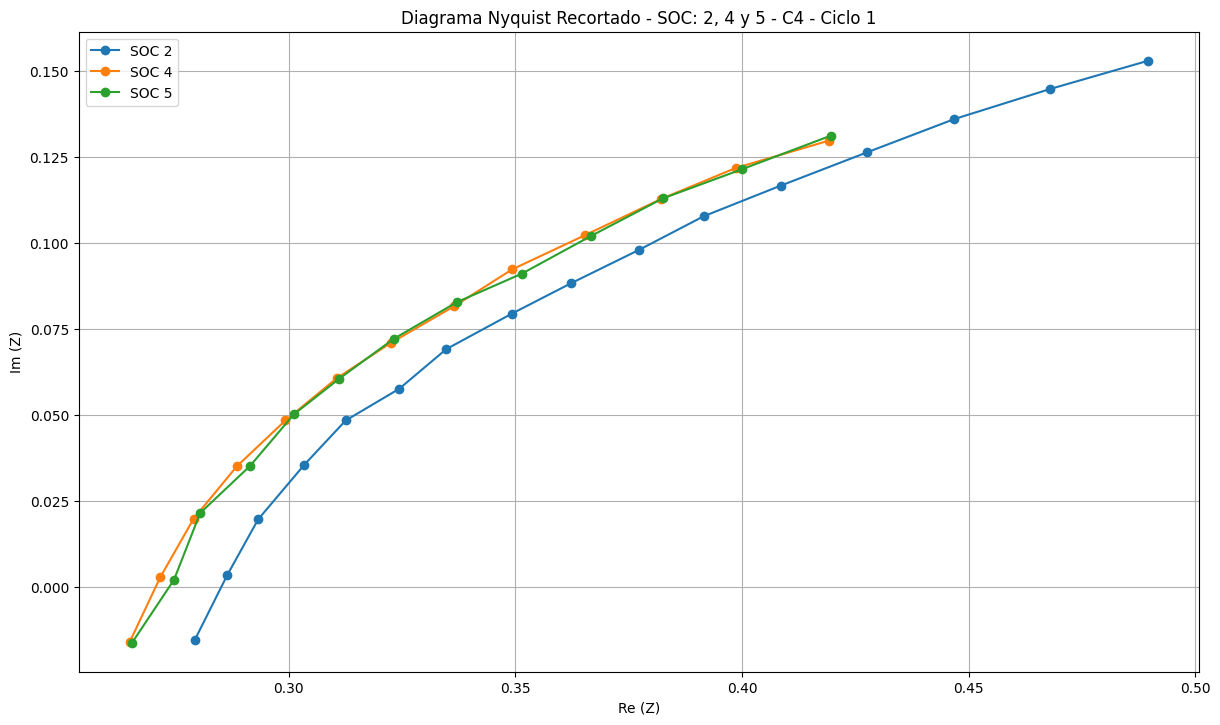

In [136]:
ciclo = 0

fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_soc2[ciclo][:i_EIS_SOC2[ciclo]],x_soc2[ciclo][:i_EIS_SOC2[ciclo]], marker='o', label="SOC 2")
ax5.plot(r_soc4[ciclo][:i_EIS_SOC4[ciclo]],x_soc4[ciclo][:i_EIS_SOC4[ciclo]], marker='o', label="SOC 4")
ax5.plot(r_soc5[ciclo][:i_EIS_SOC5[ciclo]],x_soc5[ciclo][:i_EIS_SOC5[ciclo]], marker='o', label="SOC 5")
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist Recortado - SOC: 2, 4 y 5 - C4 - Ciclo 1")
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

### Ciclo 20: SOC 2, 4 y 5

Text(0.5, 0, 'Re (Z)')

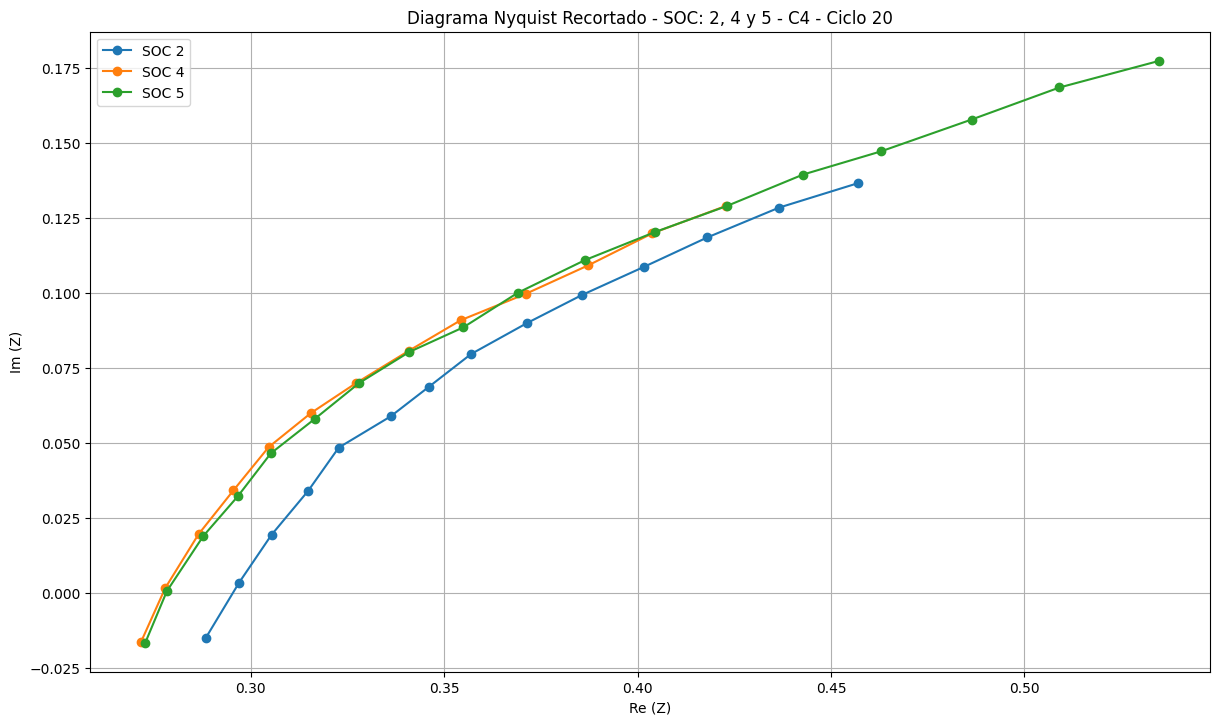

In [135]:
ciclo = 19

fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_soc2[ciclo][:i_EIS_SOC2[ciclo]],x_soc2[ciclo][:i_EIS_SOC2[ciclo]], marker='o', label="SOC 2")
ax5.plot(r_soc4[ciclo][:i_EIS_SOC4[ciclo]],x_soc4[ciclo][:i_EIS_SOC4[ciclo]], marker='o', label="SOC 4")
ax5.plot(r_soc5[ciclo][:i_EIS_SOC5[ciclo]],x_soc5[ciclo][:i_EIS_SOC5[ciclo]], marker='o', label="SOC 5")
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist Recortado - SOC: 2, 4 y 5 - C4 - Ciclo " +str(ciclo+1))
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

### Ciclo 50: SOC 2, 4 y 5

Text(0.5, 0, 'Re (Z)')

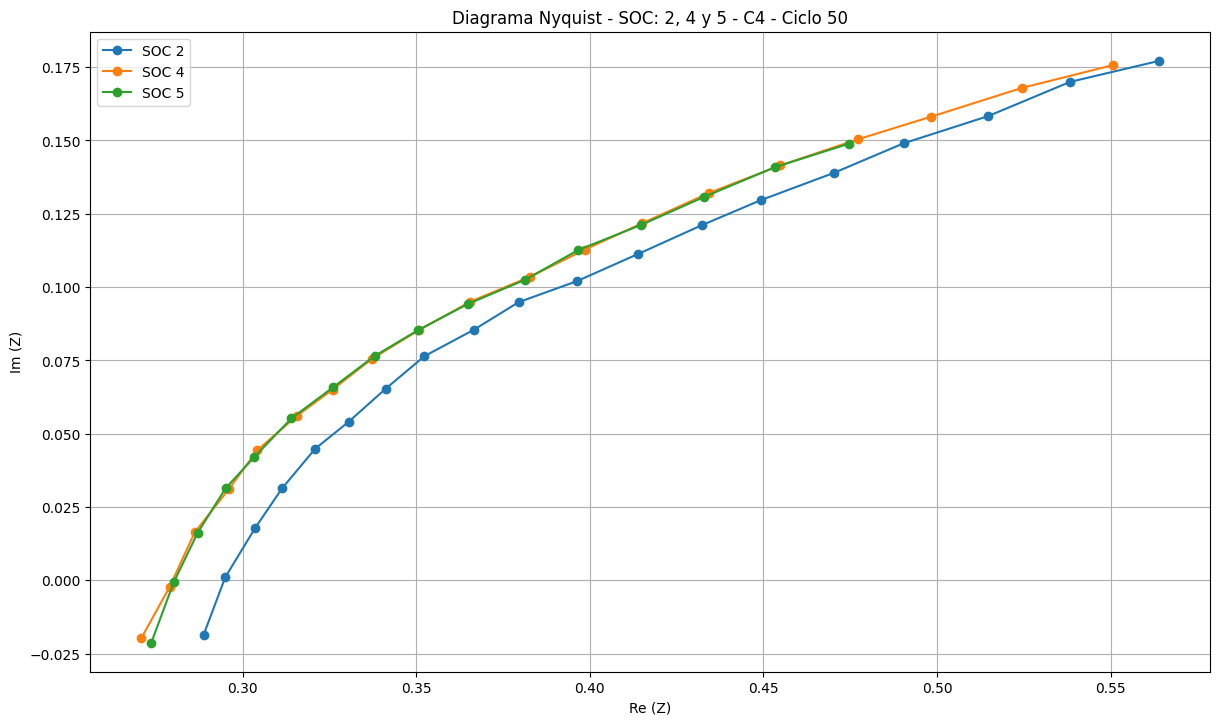

In [134]:
ciclo = 49

fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_soc2[ciclo][:i_EIS_SOC2[ciclo]],x_soc2[ciclo][:i_EIS_SOC2[ciclo]], marker='o', label="SOC 2")
ax5.plot(r_soc4[ciclo][:i_EIS_SOC4[ciclo]],x_soc4[ciclo][:i_EIS_SOC4[ciclo]], marker='o', label="SOC 4")
ax5.plot(r_soc5[ciclo][:i_EIS_SOC5[ciclo]],x_soc5[ciclo][:i_EIS_SOC5[ciclo]], marker='o', label="SOC 5")
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist - SOC: 2, 4 y 5 - C4 - Ciclo " +str(ciclo+1))
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

### Ciclo 70: SOC 2, 4 y 5

Text(0.5, 0, 'Re (Z)')

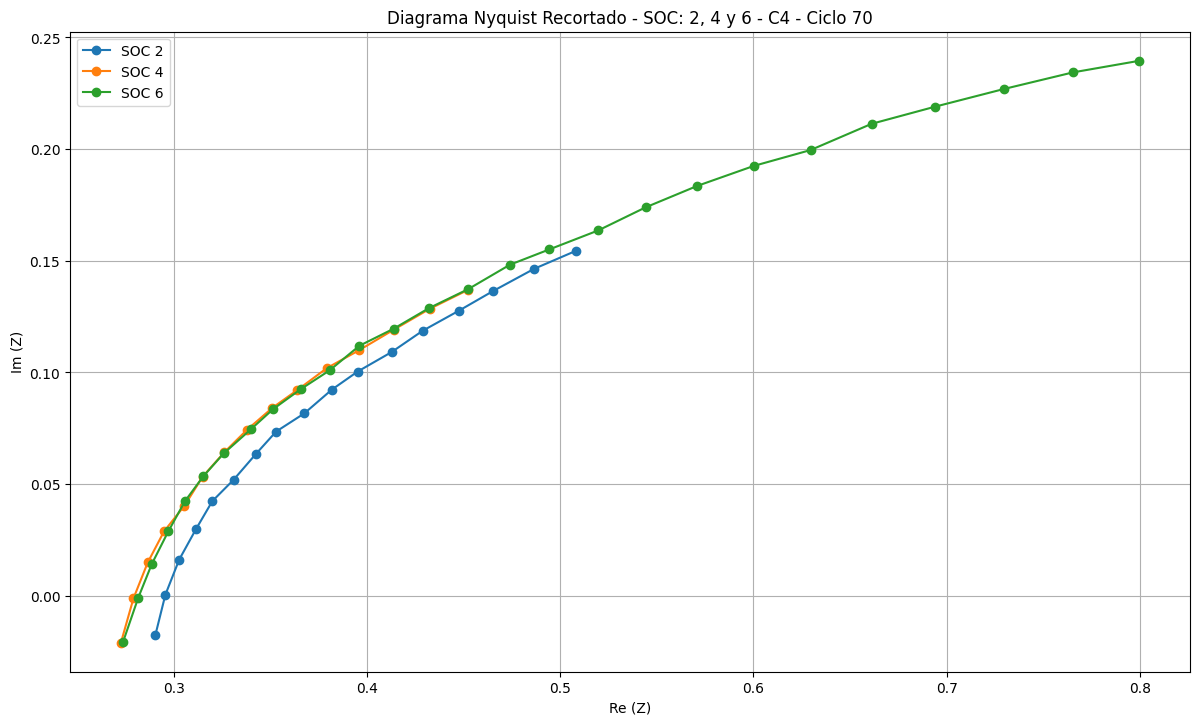

In [118]:
ciclo = 69

fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_soc2[ciclo][:i_EIS_SOC2[ciclo]],x_soc2[ciclo][:i_EIS_SOC2[ciclo]], marker='o', label="SOC 2")
ax5.plot(r_soc4[ciclo][:i_EIS_SOC4[ciclo]],x_soc4[ciclo][:i_EIS_SOC4[ciclo]], marker='o', label="SOC 4")
ax5.plot(r_soc5[ciclo][:i_EIS_SOC5[ciclo]],x_soc5[ciclo][:i_EIS_SOC5[ciclo]], marker='o', label="SOC 6")
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist Recortado - SOC: 2, 4 y 6 - C4 - Ciclo " +str(ciclo+1))
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

# Frecuencia de corte: ciclo constante, estados variables

In [114]:
estados = [1, 2, 3, 4, 5, 6, 7, 8, 9]


### Ciclo 1

Text(0.5, 0, 'State')

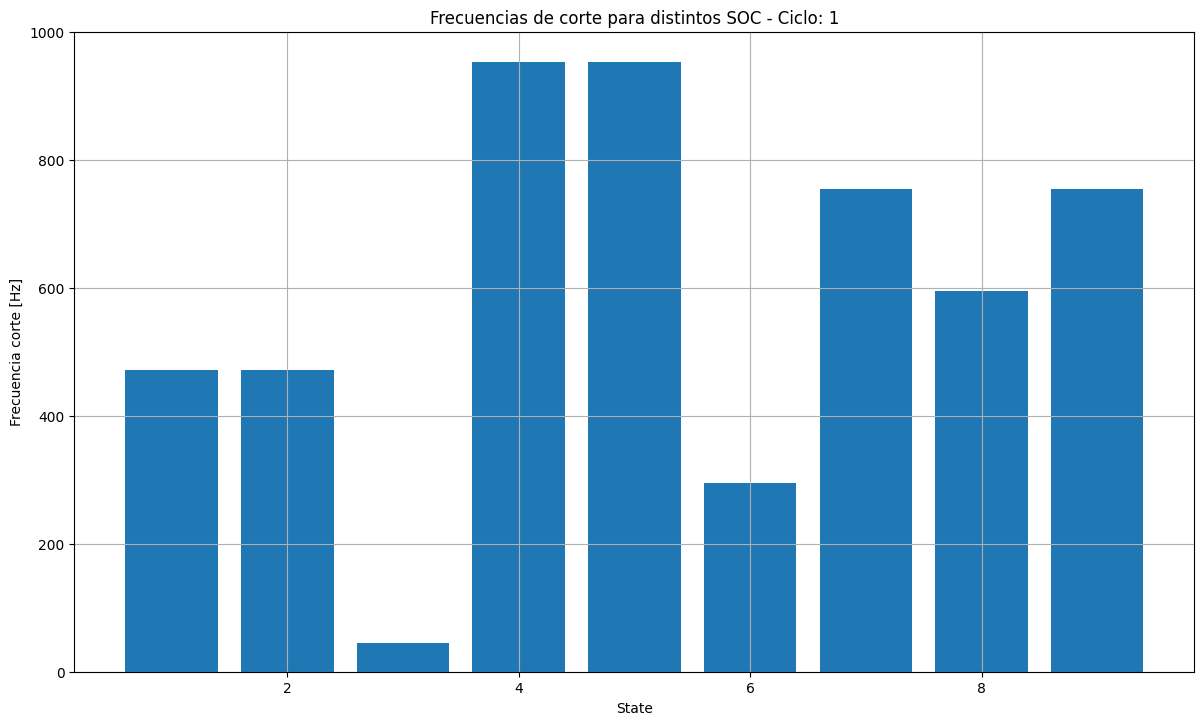

In [125]:
ciclo = 0
freq_states = [frecuencias[i_EIS_SOC1[ciclo]], frecuencias[i_EIS_SOC2[ciclo]], frecuencias[i_EIS_SOC3[ciclo]],
                frecuencias[i_EIS_SOC4[ciclo]], frecuencias[i_EIS_SOC5[ciclo]], frecuencias[i_EIS_SOC6[ciclo]],
                frecuencias[i_EIS_SOC7[ciclo]], frecuencias[i_EIS_SOC8[ciclo]], frecuencias[i_EIS_SOC9[ciclo]]]
fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.bar(estados, freq_states)
#ax5.legend()
ax5.grid()
ax5.set_title("Frecuencias de corte para distintos SOC - Ciclo: " +str(ciclo+1))
ax5.set_ylabel("Frecuencia corte [Hz]")
ax5.set_xlabel("State")

### Ciclo 10

Text(0.5, 0, 'State')

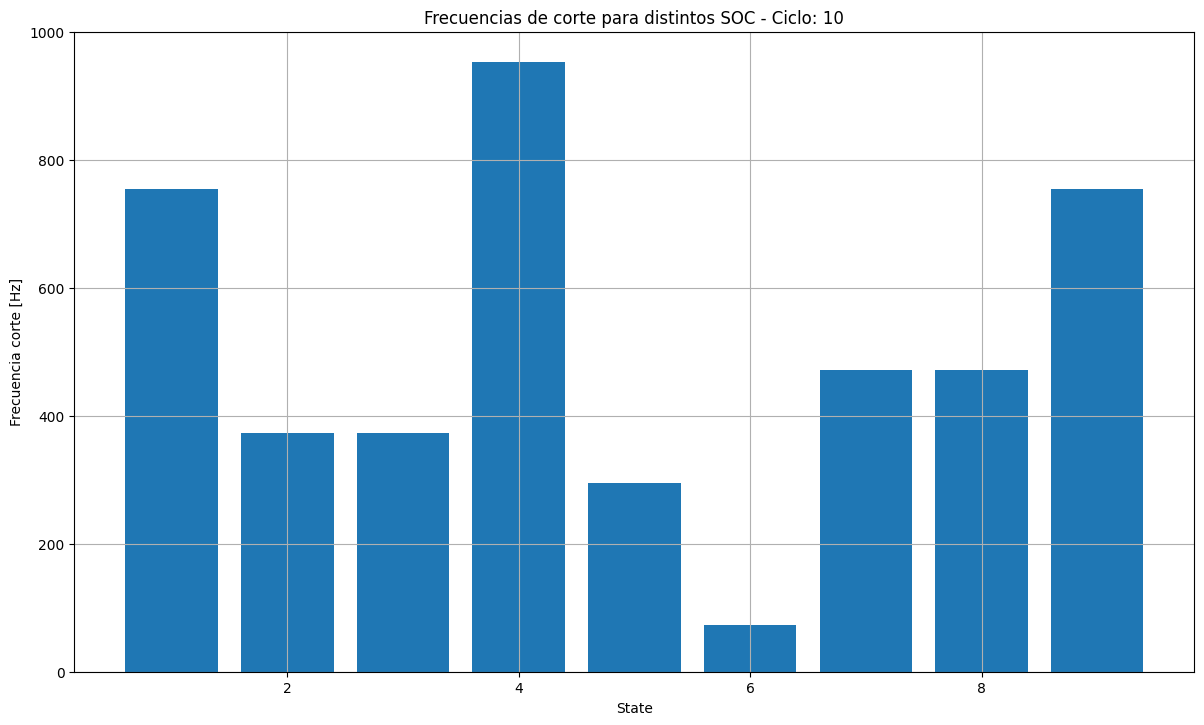

In [126]:
ciclo = 9
freq_states = [frecuencias[i_EIS_SOC1[ciclo]], frecuencias[i_EIS_SOC2[ciclo]], frecuencias[i_EIS_SOC3[ciclo]],
                frecuencias[i_EIS_SOC4[ciclo]], frecuencias[i_EIS_SOC5[ciclo]], frecuencias[i_EIS_SOC6[ciclo]],
                frecuencias[i_EIS_SOC7[ciclo]], frecuencias[i_EIS_SOC8[ciclo]], frecuencias[i_EIS_SOC9[ciclo]]]
fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.bar(estados, freq_states)
#ax5.legend()
ax5.grid()
ax5.set_title("Frecuencias de corte para distintos SOC - Ciclo: " +str(ciclo+1))
ax5.set_ylabel("Frecuencia corte [Hz]")
ax5.set_xlabel("State")

### Ciclo 40

Text(0.5, 0, 'State')

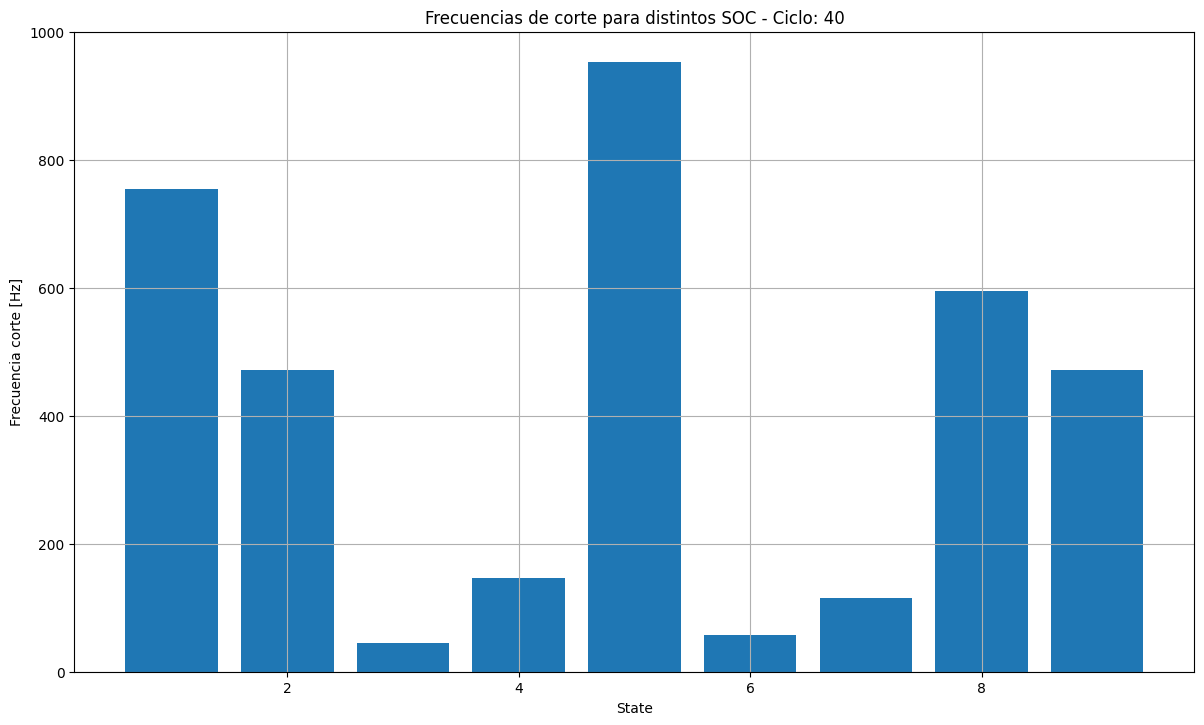

In [127]:
ciclo = 39
freq_states = [frecuencias[i_EIS_SOC1[ciclo]], frecuencias[i_EIS_SOC2[ciclo]], frecuencias[i_EIS_SOC3[ciclo]],
                frecuencias[i_EIS_SOC4[ciclo]], frecuencias[i_EIS_SOC5[ciclo]], frecuencias[i_EIS_SOC6[ciclo]],
                frecuencias[i_EIS_SOC7[ciclo]], frecuencias[i_EIS_SOC8[ciclo]], frecuencias[i_EIS_SOC9[ciclo]]]
fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.bar(estados, freq_states)
#ax5.legend()
ax5.grid()
ax5.set_title("Frecuencias de corte para distintos SOC - Ciclo: " +str(ciclo+1))
ax5.set_ylabel("Frecuencia corte [Hz]")
ax5.set_xlabel("State")

### Ciclo 60

Text(0.5, 0, 'State')

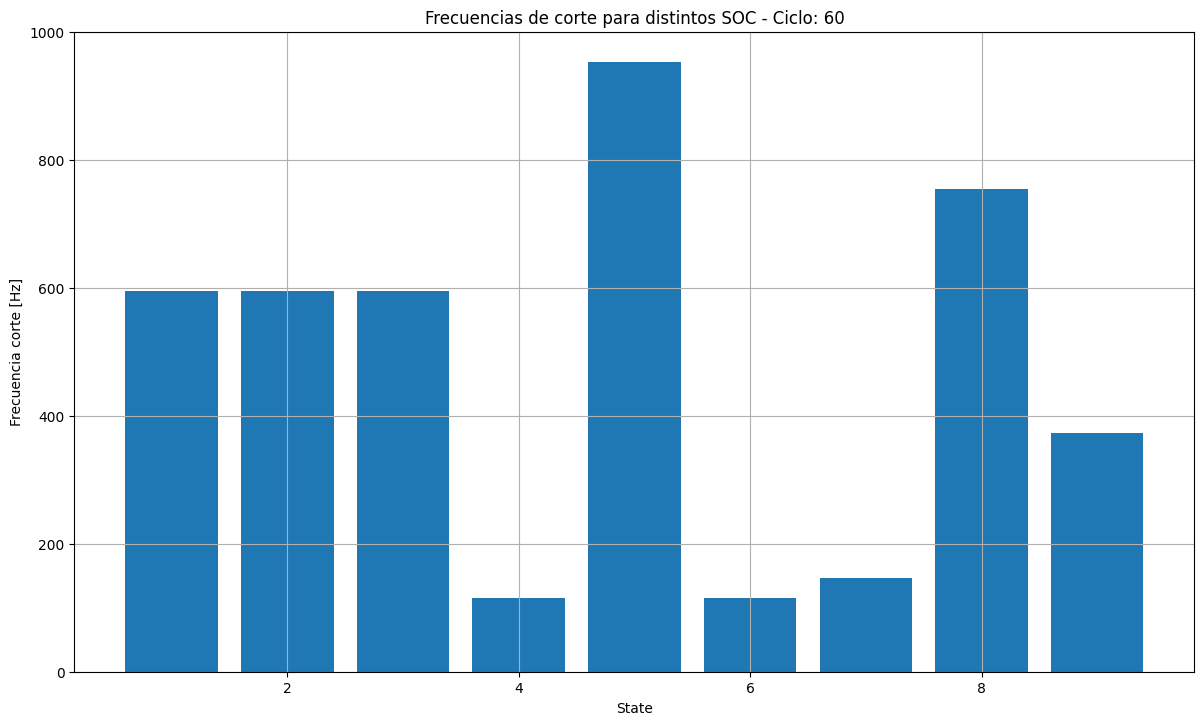

In [128]:
ciclo = 59
freq_states = [frecuencias[i_EIS_SOC1[ciclo]], frecuencias[i_EIS_SOC2[ciclo]], frecuencias[i_EIS_SOC3[ciclo]],
                frecuencias[i_EIS_SOC4[ciclo]], frecuencias[i_EIS_SOC5[ciclo]], frecuencias[i_EIS_SOC6[ciclo]],
                frecuencias[i_EIS_SOC7[ciclo]], frecuencias[i_EIS_SOC8[ciclo]], frecuencias[i_EIS_SOC9[ciclo]]]
fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.bar(estados, freq_states)
#ax5.legend()
ax5.grid()
ax5.set_title("Frecuencias de corte para distintos SOC - Ciclo: " +str(ciclo+1))
ax5.set_ylabel("Frecuencia corte [Hz]")
ax5.set_xlabel("State")

# Optimizacion

In [178]:
# Se toma el STATE V - ciclo 50 - C4
import numpy as np

cycle = 49
Ns = i_EIS_SOC5[cycle]  # Indice del sample del EIS donde se corta para la curva
points = np.zeros(shape=(Ns,2))
for i in range(Ns):
    points[i,0] = r_soc5[cycle][i] # agregar resistencia del ciclo y de la frecuencia
    points[i,1] = x_soc5[cycle][i] # agregar reactancia del ciclo y de la frecuencia

print("Frecuencia corte - State V - C4 - Ciclo 50:", frecuencias[Ns], "[Hz]")

Frecuencia corte - State V - C4 - Ciclo 50: 596 [Hz]


In [162]:
# Codigo con ChatGPT
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, minimize, NonNegativeReals
import pyomo.environ as pyo

# Crear el modelo
model = ConcreteModel()

model.p1 = Var()
model.p2 = Var()
model.p3 = Var()

# Conjunto de puntos
N = len(points)
model.i = pyo.RangeSet(N)

# Parámetros: coordenadas de los puntos
model.r = pyo.Param(model.i, initialize=lambda model, i: points[i-1, 0])
model.x = pyo.Param(model.i, initialize=lambda model, i: points[i-1, 1])

def objective_rule(model):
    return sum(model.r[i]**2 + model.x[i]**2 + model.p1*model.r[i] + model.p2*model.x[i] + model.p3 for i in model.i)

model.obj = Objective(rule=objective_rule, sense=minimize)

# Resolver el problema
solver = SolverFactory('gurobi')  # Puedes usar cualquier solver compatible, por ejemplo 'glpk'
solver.solve(model, tee=True)

# Resultados
#print(f"Centro de la circunferencia: ({model.cx.value}, {model.cy.value})")
#print(f"Radio de la circunferencia: {model.r.value}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpbrrrx_ln.pyomo.lp
Reading time = 0.00 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x36242e2d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible or unbounded model
model.name="unknown";
    - termination condition: infeasibleOrUnbounded
    - message from solver: Problem pr

{'Problem': [{'Name': 'x1', 'Lower bound': '-inf', 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1, 'Number of variables': 4, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 4, 'Number of nonzeros': 1, 'Sense': 'minimize'}], 'Solver': [{'Status': 'warning', 'Return code': '0', 'Message': 'Problem proven to be infeasible or unbounded.', 'Termination condition': 'infeasibleOrUnbounded', 'Termination message': 'Problem proven to be infeasible or unbounded.', 'Wall time': '0.0', 'Error rc': 0, 'Time': 0.20070338249206543}]}

Intento 2

In [179]:
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, minimize, NonNegativeReals, Param, RangeSet
import numpy as np


# Crear el modelo
model = ConcreteModel()

# Variables de decisión: coeficientes de la circunferencia
model.p1 = Var()
model.p2 = Var()
model.p3 = Var()

# Conjunto de puntos
N = len(points)
model.i = RangeSet(N)

# Parámetros: coordenadas de los puntos
model.r = Param(model.i, initialize=lambda model, i: points[i-1, 0])
model.x = Param(model.i, initialize=lambda model, i: points[i-1, 1])

# Función objetivo: Minimizar la suma de los cuadrados de las diferencias (residuos)
def objective_rule(model):
    return sum((model.r[i]**2 + model.x[i]**2 + model.p1*model.r[i] + model.p2*model.x[i] + model.p3)**2 for i in model.i)

model.obj = Objective(rule=objective_rule, sense=minimize)

# Resolver el problema
solver = SolverFactory('gurobi')  # Puedes usar cualquier solver compatible, por ejemplo 'glpk'
solver.solve(model, tee=True)

# Calcular el centro y el radio de la circunferencia
cx = -model.p1() / 2
cy = -model.p2() / 2
r = np.sqrt(model.p1()**2 + model.p2()**2 - 4*model.p3()) / 2

# Resultados
print(f"Centro de la circunferencia: ({cx}, {cy})")
print(f"Radio de la circunferencia: {r}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpwv4dk9w1.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x174213b0
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 4e+00]
  QObjective range [2e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

## Circunferencia en gráfico

Text(0.5, 0, 'Re (Z)')

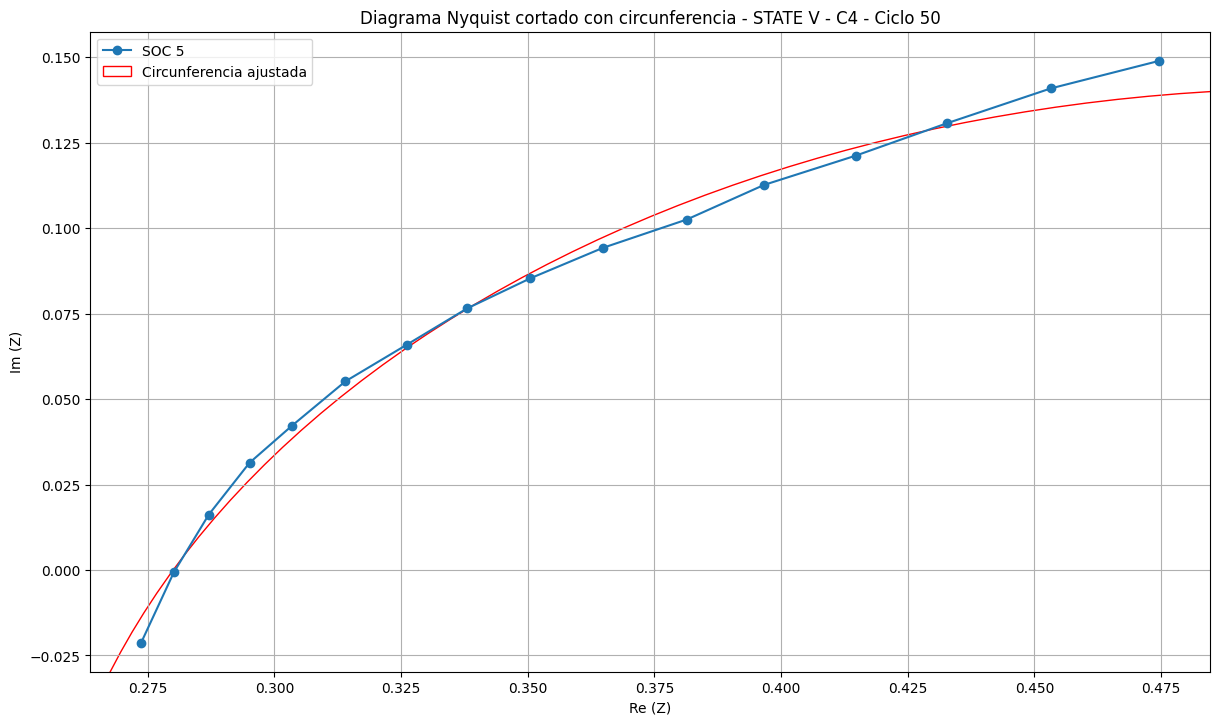

In [181]:
ciclo = 49

fig5 = plt.figure(figsize=(14,8))
ax5 = plt.axes([0.1, 0.1, 0.8, 0.8])
ax5.plot(r_soc5[ciclo][:i_EIS_SOC5[ciclo]],x_soc5[ciclo][:i_EIS_SOC5[ciclo]], marker='o', label="SOC 5")
# Agregar circunferencia
circle = plt.Circle((cx, cy), r, color='r', fill=False, label='Circunferencia ajustada')
ax5.add_artist(circle)
ax5.legend()
ax5.grid()
ax5.set_title("Diagrama Nyquist cortado con circunferencia - STATE V - C4 - Ciclo " +str(ciclo+1))
ax5.set_ylabel("Im (Z)")
ax5.set_xlabel("Re (Z)")

### Prueba
Al usar el código completo de ChatGPT se observa que se están entregando todos los puntos del EIS y no aquellos puntos que corresponden a las altas frecuencias.

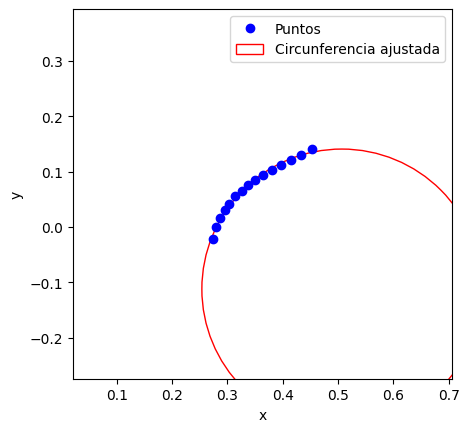

In [180]:
# Graficar los puntos y la circunferencia ajustada
fig, ax = plt.subplots()

# Graficar los puntos
ax.plot(points[:, 0], points[:, 1], 'bo', label='Puntos')

# Crear un objeto Circle y agregarlo al gráfico
circle = plt.Circle((cx, cy), r, color='r', fill=False, label='Circunferencia ajustada')
ax.add_artist(circle)

# Configurar límites del gráfico
ax.set_xlim(min(points[:, 0]) - r, max(points[:, 0]) + r)
ax.set_ylim(min(points[:, 1]) - r, max(points[:, 1]) + r)

# Etiquetas y leyenda
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_aspect('equal', 'box')